<a href="https://colab.research.google.com/github/wilbertcaine/COMP4211/blob/main/Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://drive.google.com/file/d/199mVXHt5cxT68gBXCcucMjtJzCwvc8ud/view?usp=sharing
# https://drive.google.com/file/d/1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA/view?usp=sharing
# https://drive.google.com/file/d/1yjsMICWqHdEUhF758ndq0hLO96FrYWkR/view?usp=sharing
%cd /content
!mkdir -p dataset
%cd /content/dataset
!gdown --id 199mVXHt5cxT68gBXCcucMjtJzCwvc8ud
!gdown --id 1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA
!gdown --id 1yjsMICWqHdEUhF758ndq0hLO96FrYWkR
%cd ../

/content
/content/dataset
Downloading...
From: https://drive.google.com/uc?id=199mVXHt5cxT68gBXCcucMjtJzCwvc8ud
To: /content/dataset/train.csv
100% 7.62M/7.62M [00:00<00:00, 24.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA
To: /content/dataset/Test_Jan.csv
100% 124k/124k [00:00<00:00, 58.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yjsMICWqHdEUhF758ndq0hLO96FrYWkR
To: /content/dataset/Predict_Jan.csv
100% 20.7k/20.7k [00:00<00:00, 29.8MB/s]
/content


In [18]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

!pip install torchsummaryX

import matplotlib.pyplot as plt
import os.path as osp
from torchsummaryX import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# FC_Net

In [16]:
class FC_Net_Dataset(Dataset):
    def __init__(self, split, eval_len=1, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test
        """
        super(FC_Net_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[split])
        self.eval_len = eval_len

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.data) - self.eval_len)
        return self.data[idx][1:], np.reshape(self.data[idx][0], -1)

    def __len__(self):
        return len(self.data)

In [5]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()

        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.bn1 = nn.BatchNorm1d(64, affine=True)
        self.fc3 = nn.Linear(64, 8)
        self.bn2 = nn.BatchNorm1d(8, affine=True)
        self.fc4 = nn.Linear(8, 1)
        self.relu = nn.ReLU(inplace=True)
 
    def forward(self, x):
        x = x.float()

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)
        
        return x

In [63]:
def train_epoch(net, optimizer, loss_fn, dataloader, epoch, train_size, writer=None, device='cpu'):
    ep_loss = 0.0
    num_iter = len(dataloader)
    net.train()
    grad_max = 100.
    for n_iter, (xs, y) in enumerate(dataloader):
        curr_iter = epoch * num_iter + n_iter
        xs, y = xs.to(device), y.to(device)
        pred = net(xs) ## step 1. get output
        loss = loss_fn(pred, y) ## step 2. compute loss
        optimizer.zero_grad()
        loss.backward() ## step 3. backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), grad_max) ## L2-norm gradient clipping
        optimizer.step() ## step 4. update model weigth
        if writer is not None:
            writer.add_scalar('Loss/train', loss.data, curr_iter)
        # print("\n[ITER %d] LOSS: %.4f" % (curr_iter, loss.data))
        ep_loss += loss.data
        if n_iter + 1 == train_size:
            break
    ep_loss /= train_size
    if writer is not None:
        writer.add_scalar('EpLoss/train', ep_loss, epoch)
    return ep_loss

@torch.no_grad()
def val_epoch(net, loss_fn, dataloader, epoch, val_set, val_size, writer=None, device='cpu'):
    ep_loss = 0.0
    net.eval()
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(dataloader):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
        if n_iter + 1 == val_size:
            break
    ep_loss /= val_size

    if writer is not None:
        writer.add_scalar('EpLoss/val', ep_loss, epoch)
    return ep_loss

def train(net, train_set, val_set, test_set, loss_fn, batch_size, lr, n_epoch, train_size, val_size, name='net'):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1)

    save_dir = f'drive/MyDrive/COMP4211/project/logs/{name}_{batch_size}_{lr}'
    writer = SummaryWriter(log_dir=osp.join(save_dir, 'log'))
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_ep_losses, val_ep_losses = [], []
    for epoch in range(n_epoch):
        train_loss = train_epoch(net, optimizer, loss_fn, train_loader, epoch, train_size, writer, device)
        val_loss = val_epoch(net, loss_fn, val_loader, epoch, val_set, val_size, writer, device)
        train_ep_losses.append(train_loss)
        val_ep_losses.append(val_loss)
        if (epoch + 1) % 5 == 0:
            print("[EP \t%d] \t\tTrain LOSS: \t%.4f \t\tVal LOSS: \t%.4f" % (epoch + 1, train_loss, val_loss))
            os.makedirs(osp.join(save_dir, 'weights'), exist_ok=True)
            torch.save(net.state_dict(), osp.join(save_dir, 'weights/ep%d.pth' % (epoch + 1)))
    
    plt.plot(torch.tensor(train_ep_losses).cpu().numpy(), label='train')
    plt.plot(torch.tensor(val_ep_losses).cpu().numpy(), label='val')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.show()

@torch.no_grad()
def test(net, loss_fn, test_data, batch_size, lr, epoch=90, name='net'):
    net.eval()
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    save_dir = f'drive/MyDrive/COMP4211/project/logs/{name}_{batch_size}_{lr}'
    net.load_state_dict(torch.load(osp.join(save_dir, 'weights/ep%d.pth' % epoch)))
    test_loader = DataLoader(test_set, batch_size=1)
    ep_loss = 0.0
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(test_loader):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
    ep_loss /= len(test_loader)
    return ep_loss

[EP 	5] 		Train LOSS: 	1101.3987 		Val LOSS: 	1128.9337
[EP 	10] 		Train LOSS: 	935.8990 		Val LOSS: 	973.2666
[EP 	15] 		Train LOSS: 	733.1577 		Val LOSS: 	793.5956
[EP 	20] 		Train LOSS: 	500.5809 		Val LOSS: 	516.5334
[EP 	25] 		Train LOSS: 	314.8271 		Val LOSS: 	574.6668
[EP 	30] 		Train LOSS: 	188.4583 		Val LOSS: 	287.9149
[EP 	35] 		Train LOSS: 	124.2591 		Val LOSS: 	175.3451
[EP 	40] 		Train LOSS: 	105.8859 		Val LOSS: 	102.5789
[EP 	45] 		Train LOSS: 	102.1877 		Val LOSS: 	144.9618
[EP 	50] 		Train LOSS: 	100.7493 		Val LOSS: 	111.8115
[EP 	55] 		Train LOSS: 	99.6745 		Val LOSS: 	116.7001
[EP 	60] 		Train LOSS: 	99.1711 		Val LOSS: 	117.5502
[EP 	65] 		Train LOSS: 	99.1889 		Val LOSS: 	124.2923
[EP 	70] 		Train LOSS: 	98.7120 		Val LOSS: 	101.2808
[EP 	75] 		Train LOSS: 	98.2721 		Val LOSS: 	135.3840
[EP 	80] 		Train LOSS: 	98.2772 		Val LOSS: 	121.8438
[EP 	85] 		Train LOSS: 	99.2169 		Val LOSS: 	103.7250
[EP 	90] 		Train LOSS: 	98.2156 		Val LOSS: 	94.0673
[EP 	95] 		Train L

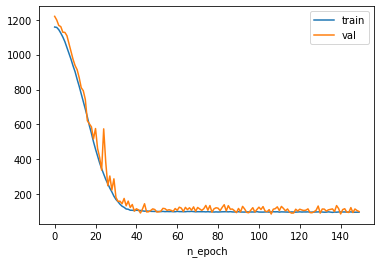

In [42]:
train_set = FC_Net_Dataset(split=0)
val_set = FC_Net_Dataset(split=1)

np.random.seed(1)
fc_net = FC_Net();
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 150, 1e-3
train_size, val_size = 365, 365
train(fc_net, train_set, val_set, test_set, loss_fn, batch_size, lr, n_epoch, train_size, val_size, name='fc_net')

In [64]:
net = FC_Net()
test_set = FC_Net_Dataset(split=2)
test_loss = test(net, loss_fn, test_set, batch_size, lr, epoch=90, name='fc_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	102.2832


# LSTM

In [ ]:
class R_Net_Dataset(Dataset):
    def __init__(self, split, eval_len=1, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test
        """
        super(FC_Net_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[split])
        self.eval_len = eval_len

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.data) - self.eval_len)
        return self.data[idx][1:], np.reshape(self.data[idx][0], -1)

    def __len__(self):
        return len(self.data)

In [ ]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()

        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.bn1 = nn.BatchNorm1d(64, affine=True)
        self.fc3 = nn.Linear(64, 8)
        self.bn2 = nn.BatchNorm1d(8, affine=True)
        self.fc4 = nn.Linear(8, 1)
        self.relu = nn.ReLU(inplace=True)
 
    def forward(self, x):
        x = x.float()

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)
        
        return x